**Import Modules**


In [1]:
from distutils.command.build import build
from multiprocessing.spawn import old_main_modules
import os

from pyparsing import col
from HALSS_utils.point_cloud_to_image import collect_lidar, pc_to_surf_normal, downsample_pointcloud, downsample_pointcloud_dict 

from pprint import pprint
from datetime import datetime
from HALSS_utils.network_utils.model_arch import *
from HALSS_utils.network_utils.augment import *
from HALSS_utils.seg_utils import *
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import skfmm 

# requires Python 3.5.3 :: Anaconda 4.4.0
# pip install opencv-python
import cv2
import numpy as np

from datetime import datetime

from HALSS_utils.halss_utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


**Initialize Network**

In [2]:
# #####################
# Network Setup
# #####################
kernel_size = 3
nbase = [3, 32, 64, 128, 256]  # Number of channels per layer
nout = 1  # Number of outputs

net = Unet_drop(nbase, nout, kernel_size)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

net.load_model(os. getcwd() + f"\\HALSS_utils\\network_utils\\segnet_epoch_1000.pth")
net.eval()
net.to(device);  # remove semi-colon to see net structure


NVIDIA GeForce RTX 3090


**Import Demo Pointcloud**


In [3]:
pcd = np.load(os. getcwd() + '\\demo_pointcloud.npy')
pcd_culled = {}
x_cell_size = .5 # Size of cell in x direction
y_cell_size = .5 # Size of cell in y direction

pcd_combined = o3d.geometry.PointCloud()
pcd_combined.points = o3d.utility.Vector3dVector(pcd)
#o3d.visualization.draw_plotly([pcd_combined], point_sample_factor=0.2) # Draws in Notebook but looks bad
o3d.visualization.draw_geometries([pcd_combined]) # Draws in separate window but looks good

**Convert Pointcloud to Surface Normal**

To create the surface normal, a we linearly interpolate a function to fit the pointcloud. We then sample the function at equal grid spacings. The gradient of the surface is then found and used to create the unit normal vector $\hat{u} = \frac{\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}} {\left|\left|\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}\right|\right|}$. This vector, $\hat{u}$, is represented by the $r$, $g$, and $b$ values which is unit normal vector to the surface at that point.

In [4]:
png = pc_to_surf_normal(pcd)
pcd_culled = downsample_pointcloud_dict(pcd_culled, pcd, x_cell_size, y_cell_size) # Bin the point cloud and choose the maximum and minimum z value for each bin
png = mask_surf_norm(pcd_culled, pcd, png, png, x_cell_size, y_cell_size) # Mask out points that are in the convex hull around the point cloud in the XY plane but not in the point cloud
png_scaled = scale_image(png, pcd)

In [5]:
# #####################
# Find UV to World NED Scale Factor
# #####################
min_new_x = 0
max_new_x = png_scaled.shape[1]
min_new_y = 0
max_new_y = png_scaled.shape[0]

sf_x, sf_y = scale_uv_2_world(pcd, min_new_x, min_new_y, max_new_x, max_new_y)

# #####################
# Find NED Origin in UV Pixel Space
# #####################
x_pcd_to_surface = min_new_x - (max_new_x-min_new_x)/(pcd[:,0].max()- pcd[:,0].min()) * (pcd[:,0].min())
y_pcd_to_surface = min_new_y + (max_new_y-min_new_y) * (0 - pcd[:,1].min())/(pcd[:,1].max() - pcd[:,1].min())

org_x = x_pcd_to_surface
org_y = max_new_y - y_pcd_to_surface

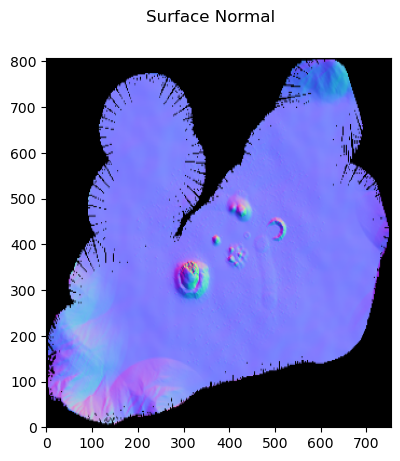

In [6]:
plt.imshow(png_scaled[:,:,[2,1,0]], extent = [0, sf_x*png_scaled.shape[0], 0, sf_x*png_scaled.shape[1]])
plt.suptitle('Surface Normal')
plt.show()

**Run Segmentation Network**

Run the surface normal through the segmentation network. Monte Carlo Dropout is used to approximate the Bayesian Uncertainty in the Network. The network architecture is based on Segnet with Dropout after each encoder and decoder unit. The output safety map is the mean of the MC samples and the variance map is the vairance of the MC samples. Unobserved reigons of the terrain are considered unsafe.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


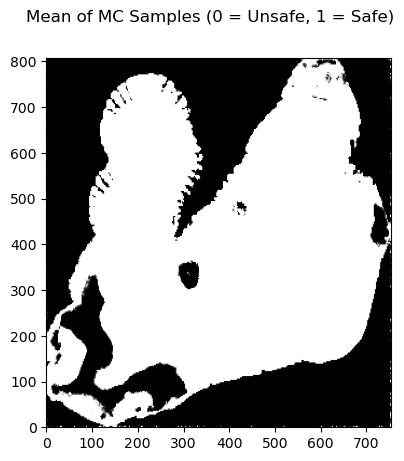

In [7]:
safety_map, var_scaled, norm_resized_var = run_network(normalize(png.transpose(2,0,1)), net, device, pcd, 50)
plt.imshow(safety_map, extent = [0, sf_x*safety_map.shape[0], 0, sf_x*safety_map.shape[1]])
plt.suptitle('Mean of MC Samples (0 = Unsafe, 1 = Safe)')
plt.show()

Text(0.5, 0.98, 'Variance of MC Samples (0 = Low Variance, 1 = High Variance)')

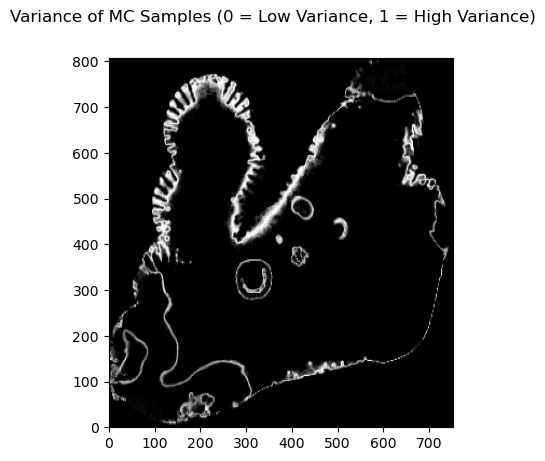

In [8]:
plt.imshow(norm_resized_var, cmap = 'gray', extent = [0, sf_x*norm_resized_var.shape[0], 0, sf_x*norm_resized_var.shape[1]])
plt.suptitle('Variance of MC Samples (0 = Low Variance, 1 = High Variance)')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


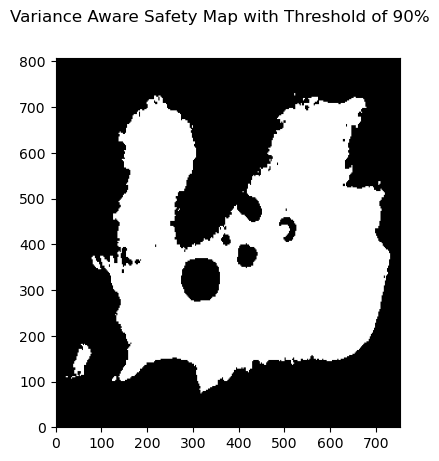

In [9]:
var_thresh = 0.9
thresh_safety = var_aware_safety_map(safety_map, norm_resized_var, var_thresh)
plt.imshow(thresh_safety, extent = [0, sf_x*thresh_safety.shape[0], 0, sf_x*thresh_safety.shape[1]])
plt.suptitle('Variance Aware Safety Map with Threshold of %i'%(var_thresh*100) + '%')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


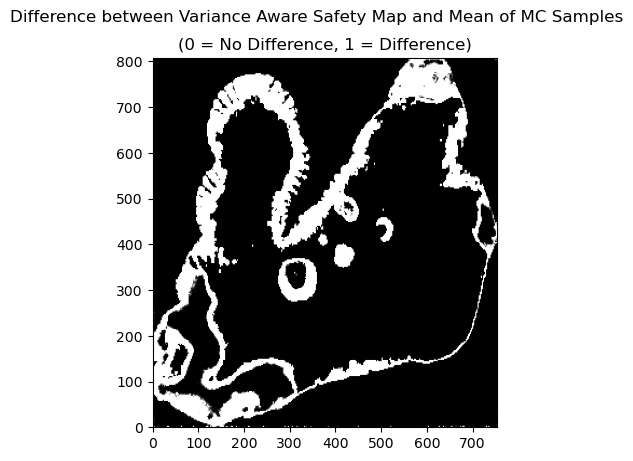

In [10]:
diff = safety_map - thresh_safety
plt.imshow(diff, extent = [0, sf_x*diff.shape[0], 0, sf_x*diff.shape[1]])
plt.suptitle('Difference between Variance Aware Safety Map and Mean of MC Samples')
plt.title('(0 = No Difference, 1 = Difference)')
plt.show()

**Determine Safe Landing Sites**

The Medial Axis Skeleton is used to determine the location of the top $N$ largest inscribed circles within the safe reigon (white pixels) of the Safety Map (Mean of MC Samples) with the constraint that the center of one circle cannot lie within any other circle. The color value of the skeleton corresponds to how far away the nearest unsafe reigon is from that point on the skeleton.

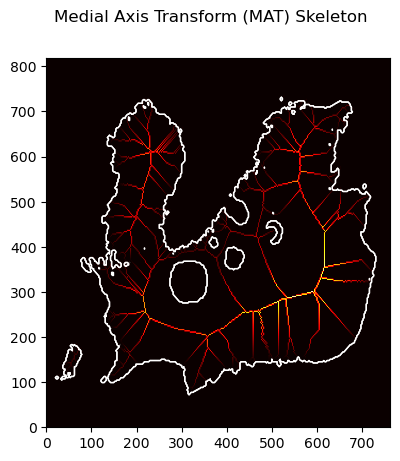

In [11]:
num_circles = 10
radii, center_coords, skel, circles, dist = landingselection(thresh_safety.astype(np.uint8), num_circles)
plt.imshow(skel, cmap='hot', extent = [0, sf_x*skel.shape[0], 0, sf_y*skel.shape[1]], origin='upper')
plt.contour(thresh_safety[:,:,0], [0,1], colors='w', linewidths=1, extent = [0, sf_x*thresh_safety.shape[0], 0, sf_y*thresh_safety.shape[1]], origin='upper')
plt.suptitle('Medial Axis Transform (MAT) Skeleton')
plt.show()

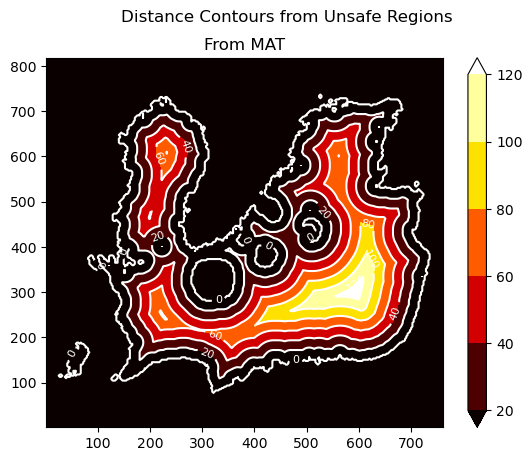

In [12]:
num_levels = 7
contours = plt.contour(sf_x*dist, num_levels, colors = 'white', origin = 'upper', extent = [0, sf_x*dist.shape[0], 0, sf_y*dist.shape[1]])
plt.clabel(contours, inline = True, fontsize = 8, colors = 'white')
plt.contourf(sf_x*dist, num_levels, cmap = 'hot', extend = 'both', origin = 'upper', extent = [0, sf_x*dist.shape[0], 0, sf_y*dist.shape[1]])
plt.colorbar()
plt.suptitle('Distance Contours from Unsafe Regions')
plt.title('From MAT')
plt.show()


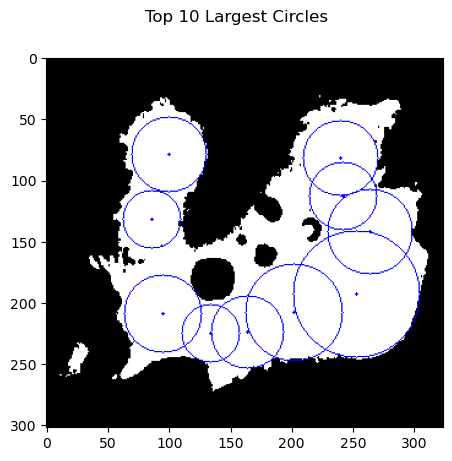

In [15]:
plt.imshow(circles)
plt.suptitle('Top %i Largest Circles' %num_circles)
plt.show()

In [14]:
# #####################
# Score Landing Sites
# #####################
max_sites = 7
center_coords_ned = np.zeros((len(radii), 3))
for idx, center in enumerate(center_coords):
    center_coords_ned[idx] = (uv2WorldNED(pcd, center_coords[idx][0][0], center_coords[idx][1][0], min_new_x, min_new_y, max_new_x, max_new_y, org_x, org_y))

scores = score_landings(center_coords[0:max_sites], 
                        center_coords_ned[0:max_sites], 
                        radii[0:max_sites], 
                        safety_map, 
                        var_scaled, 
                        pcd,
                        min_new_x, 
                        min_new_y, 
                        max_new_x, 
                        max_new_y)
print(scores.T)

[[1.         1.         0.74282111 1.         0.68847016]
 [0.76923077 1.         0.80724583 1.         0.61334849]
 [0.67307692 1.         0.70710317 1.         0.72324993]
 [0.61538462 1.         0.72868533 1.         0.87758329]
 [0.59615385 1.         0.37708825 1.         1.        ]
 [0.59615385 1.         0.41437871 1.         0.83586596]
 [0.57692308 1.         1.         1.         0.68324945]]
